## AI workshop: Rachitt Shah

### Data cleaning and preprocessing:

The JSONs had different schemas and for the LLMs to make sense of them, I've converted them into a CSV. Some known issues with the data are: 

- responses json had an invalid key for 18_1, for music type, which didn't have a question.
- Questions JSON had a question for users to understand the spacing out of episode airing frequencies, which didn't have a key in the responses JSON.

## Approach One:

My first approach is feeding the CSVs directly to the agents. This is ultimately the end process for al, but this was the fastest to demo.

There's two approaches to this:

- Use the Chat models: these models worked the best with more qualatative data, but they're also the most expensive yet best results. Prone to missing actions, and need to be prompted well. Tested models: gpt-3.5-turbo-16k(to save time on chunking) and GPT-4. GPT-4 is the best, but it's also the most expensive. GPT-3.5 is the best for the price, but it's still expensive.

- Instruct Models: text-davinci-003 performed the best on the quantative data, since it's an instruct-tuned model. This model performed best on straightforward asks, such as finding gender splits. Known constrait is token size and hallucinations when scaling to more complex prompts.

A mixed approach would be prompt selectors by langchain, which can invoke the best model for the job. Unfortunately, there's no docs for this, but this is a viable plan for prod scale deployments and reducing costs.

My agent type is zero shot, since future data is unknown, and having scalable prompts and agent pipelines is important.

In [1]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
import pandas as pd
import os
from trulens_eval import TruChain, Feedback, Huggingface, Tru
tru = Tru()

🦑 Tru initialized with db url sqlite:///default.sqlite .


### Chat template improvement

for a prod scale system, using CustomChatTemplate from Langchain is the best approach to take. 

### For prod deployment fact checking.

In [11]:
from langchain.chains import LLMCheckerChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

# Initialize the LLM (Language Model)
llm = ChatOpenAI(model="gpt-4-0613",temperature=0.3)
# Initialize the LLMCheckerChain
checker_chain = LLMCheckerChain.from_llm(llm, verbose=True)

In [16]:
os.environ["OPENAI_API_KEY"]= ''
os.environ["HUGGINGFACE_API_KEY"]=""
# openai.api_key = OPENAI_API_KEY

prompt = """
### Instructions:

As a User Researcher, your expertise lies in analyzing datasets for user research. Your task is to transform a user researcher's question into a Python code snippet using pandas. This code snippet should be designed to extract insights from the provided datasets using a blend of qualitative and quantitative methods.

**Important Guidelines**:

- **Contextual Understanding**: Recognize the context of each question and determine which dataset it pertains to. Choose the appropriate dataset for extraction.
- **Clarity and Thoroughness**: Ensure clarity in the code. Make use of clear variable names, and break down the code into smaller chunks if necessary for better readability. Deliver thorough, actionable insights with every interaction.
- **Annotations and Comments**: Each code snippet should have comments explaining the steps being taken, so you can understand and potentially modify it in the future.
- **Visual Representations**: When visual clarity is beneficial or suggested by the question, produce graphs, plots, and histograms using libraries like `matplotlib` or `seaborn`.
- **Optimization**: Ensure that the code is optimized for performance, especially when dealing with large datasets.

### Input:
Translate the user researcher's question: {input} to extract the desired information from the datasets.

### Response:
Your response should include graphs, plots, and histograms, as well as a summary of your results. Exclude code outputs, and give a comprehensive understanding of your results as a User Researcher.
"""

### Toolkits

Why have i gone for pandas agents instead of using llm-math?

- LLM-Math is not optimised for large datasets and performing complex operations which pandas can handle easily.
- If LLM-Math has to be implemented, I'd recommend having a list of quantatative operation functions created and invoked by the agent.

In [ ]:
from langchain.chains import LLMCheckerChain
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

# Initialize the LLM (Language Model)
llm = ChatOpenAI(model="gpt-4-0613",temperature=0.3)
# Initialize the LLMCheckerChain
checker_chain = LLMCheckerChain.from_llm(llm, verbose=True)

In [3]:
df_1 = pd.read_csv('/home/rachitt/qual-llm/raw_data/survey_1.csv')
df_1.head(5)

,Q.yearborn,Q.gender,Q.ethnicity,What do you use to stream TV shows or movies? Select all that apply.,"Of the two options, how do you identify?",Which statement applies to you? Select one.,Which do you currently use? Select all that apply.,"Of the below list, which platform do you use the most, right now? Select one.",Which do you currently use? Select all that apply..1,"Of the below list, which platform do you use the most, right now? Select one..1",...,How many hours per week do you spend watching TV shows?,How many hours per week do you spend watching movies?,How many hours per week do you spend playing video games?,How many hours per week do you spend listening to podcasts or audiobooks?,How many hours per week do you spend listening to music?,"Of the below list, which is your favorite to do?","When you are streaming a TV show or movie, which do you primarily prefer?","When you are streaming a TV show or movie, which do you primarily prefer?.1","When you discover a new TV show or movie, how do you typically first hear about it? Select one.",How important is it to you to be the first of your friend group to discover a new TV show or movie?
0,2004,Female,['Black or African American'],"['Smart TV', 'Roku ', 'Chromecast', 'Firestick...",Extrovert,I am a full time student,"['Hulu', 'Netflix', 'Amazon Prime Video', 'You...",Paramount +,"['Spotify', 'Apple Music', 'Pandora', 'SoundCl...",Spotify,...,9-11 hours,9-11 hours,12+ hours,0 hours,12+ hours,Listening to music,Focus entirely on the show,Watch alone,Hearing about it from a friend/family member,Not at all important
1,2000,Female,['Black or African American'],"['Roku ', 'Smartphone', 'Laptop']",Introvert,I have a part time job,"['Hulu', 'Netflix', 'Amazon Prime Video', 'Sli...",Amazon Prime Video,['Apple Music'],NaN,...,1-5 hours,1-5 hours,0 hours,0 hours,9-11 hours,Listening to music,Focus entirely on the show,Watch alone,Seeing it on social media or online,Somewhat important
2,1998,Female,['Black or African American'],"['Smart TV', 'Roku ', 'Chromecast', 'Apple TV'...",Extrovert,I have a full time job,"['Hulu', 'Netflix', 'YouTube Premium', 'Peacoc...",Netflix,"['Amazon Music', 'Apple Music', 'Pandora', 'Yo...",YouTube Music,...,1-5 hours,9-11 hours,0 hours,1-5 hours,12+ hours,Listening to music,Have it on in the background,Watch with friends/family,Seeing it on social media or online,Very important
3,2002,Female,['Black or African American'],"['Apple TV', 'Gaming console', 'Smartphone', '...",Introvert,I am a full time student,"['Apple TV+', 'Disney+', 'Funimation']",Apple TV+,"['Spotify', 'YouTube Music']",Spotify,...,1-5 hours,1-5 hours,1-5 hours,1-5 hours,1-5 hours,Watching TV shows,Focus entirely on the show,Watch with friends/family,Seeing it on social media or online,Very important
4,2002,Female,['White or Caucasian'],"['Roku ', 'Firestick', 'Smartphone', 'Laptop']",Extrovert,I have a part time job,"['Hulu', 'Netflix', 'Sling', 'Disney+', 'Param...",Paramount +,"['Spotify', 'Apple Music', 'Pandora', 'YouTube...",Apple Music,...,9-11 hours,6-8 hours,< 1 hour,0 hours,9-11 hours,Watching TV shows,Have it on in the background,Watch alone,Seeing it on social media or online,Somewhat important


In [4]:
pd_1_instruct = create_pandas_dataframe_agent(OpenAI(model="text-davinci-003", temperature=0.3), df_1, verbose=True)

In [ ]:
pd_1_instruct.run(f"{prompt} what is the average age of the respondents? Show as a graph")

In [17]:
pd_agent = create_pandas_dataframe_agent(ChatOpenAI(model="gpt-4-0613",temperature=0.3), df_1, verbose=True,agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION) 



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to count the number of respondents who prefer to watch alone and those who prefer to watch with friends/family. The relevant column in the dataframe is 'When you are streaming a TV show or movie, which do you primarily prefer?'.

Action: python_repl_ast
Action Input: df['When you are streaming a TV show or movie, which do you primarily prefer?'].value_counts()
Observation: Focus entirely on the show      147
Have it on in the background    114
Name: When you are streaming a TV show or movie, which do you primarily prefer?, dtype: int64
Thought:The output does not match the expected categories of 'Watch alone' and 'Watch with friends/family'. It seems I have used the wrong column. The correct column should be 'When you are streaming a TV show or movie, which do you primarily prefer?.1'. I will repeat the previous action with the correct column.

Action: python_repl_ast
Action Input: df['When you are streami

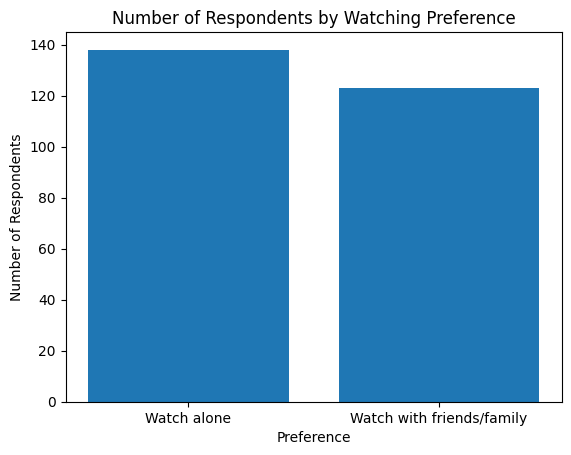


Observation: 
Thought:I have successfully generated a bar graph showing the number of respondents who prefer to watch alone vs. with friends/family. The graph shows that the number of respondents who prefer to watch alone is slightly higher than those who prefer to watch with friends/family.

Final Answer: There are 138 respondents who prefer to watch alone and 123 respondents who prefer to watch with friends/family. The bar graph visually represents these counts.

> Finished chain.


In [19]:
df_1_string = pd_agent.run(f"{prompt} How many respondents prefer to watch alone vs. with friends/family, show a graph too")

In [ ]:
print(df_1_string)
checker_chain.run(df_1_string)

In [6]:
df_2 = pd.read_csv('/home/rachitt/qual-llm/raw_data/survey_2.csv')
df_2.head(5)

,In what year were you born?,Gender:,Race/Ethnicity:(Select all that apply),"Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..5","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, please drag and drop the following Mexican fast food restaurants from favorite to least favorite..6","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..5","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop the following burger fast food restaurants from favorite to least favorite..6","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite.","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..1","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..2","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..3","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite to least favorite..4","Using a scale of 1 to 7 where 1 is your first choice and 7 is your least favorite choice, Please drag and drop your favorite chicken sandwich from these fast food restaurants from favorite

In [7]:
pd_2_instruct = create_pandas_dataframe_agent(OpenAI(model="text-davinci-003", temperature=0.3), df_2, verbose=True)

In [ ]:
pd_2_instruct.run(f"{prompt}Is Subway the most popular sandwich shop?")

In [8]:
pd_2_agent = create_pandas_dataframe_agent(ChatOpenAI(model="gpt-4-0613",temperature=0.5), df_2, verbose=True, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

In [ ]:
pd_2_agent.run(f"{prompt} What is the gender split among folks who ranked Taco bell as their top choice? Plot a piechart to show this.")

### Mutliple CSV agents

A brute force way to index CSVs, which can be used for faster A/B testing. Not a recommended way, since we're using zero shot learning, due to which the model will lose context and produce lower quality results.

There's also a known issue with multiple file agents is that for CSV agents, the OutputParser class from Langchain throws issues alot of times.

In [9]:
from langchain.agents.agent_types import AgentType

Multi_DF_agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k"),
    [df_1,df_2],
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
Multi_DF_agent.run(f"{prompt} What is the gender split among folks who ranked Taco bell as their top choice? Plot a piechart to show this.")

In [ ]:
from langchain.agents import create_pandas_dataframe_agent, create_csv_agent
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

agent = create_csv_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k"),
    ["/home/rachitt/qual-llm/raw_data/survey_2.csv", "/home/rachitt/qual-llm/raw_data/survey_1.csv"],
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

## Running Agents with monitoring

Running all of our function calls with [https://www.trulens.org/], which allows evals+feedback for our LLM calls.

In [13]:
# Initialize Huggingface-based feedback function collection class:
hugs = Huggingface()

# Define a language match feedback function using HuggingFace.
f_lang_match = Feedback(hugs.language_match).on_input_output()
# By default this will check language match on the main app input and main app
# output.

✅ In language_match, input text1 will be set to *.__record__.main_input or `Select.RecordInput` .
✅ In language_match, input text2 will be set to *.__record__.main_output or `Select.RecordOutput` .


In [14]:
truchain_checker_1 = TruChain(checker_chain, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],                                  
    tags = "prototype")

# # Instrumented chain can operate like the original:
# prompt_input=f"{prompt} What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart."

llm_response = truchain_checker_1(df_1_string)

display(llm_response)

NameError: name 'df_1_string' is not defined

In [ ]:
truchain_instruct_survey_1 = TruChain(pd_1_instruct, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],                                  
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart."

llm_response = truchain_instruct_survey_1(prompt_input)

display(llm_response)

In [ ]:
truchain_chat_survey_1 = TruChain(pd_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What is the gender split between people who use pay for the streaming service themselves vs share an account with someone?"

llm_response = truchain_chat_survey_1(prompt_input)

display(llm_response)

In [ ]:
truchain_instruct_survey_2 = TruChain(pd_2_instruct, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What is the gender split in the survey?"

llm_response = truchain_instruct_survey_2(prompt_input)

display(llm_response)

In [ ]:
truchain_chat_survey_2 = TruChain(pd_2_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} Is Subway the most popular sandwich shop?"

llm_response = truchain_chat_survey_2(prompt_input)

display(llm_response)

In [ ]:
truchain_multiple_df = TruChain(Multi_DF_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What are the top three highest ranked mexican fast food restaurants? Plot a chart.?"

llm_response = truchain_multiple_df(prompt_input)

display(llm_response)

In [2]:
tru.run_dashboard()

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.29.59:8501 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [ ]:
tru.stop_dashboard()

### Vectorstore+Agents approach

Vectorstores can significantly increase the context of the models, with a larger size.

I wished to benchmark each approach to understand which approach performed the best on question answering.

In [20]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import CSVLoader

llm = OpenAI(temperature=0)

loader = DirectoryLoader("/home/rachitt/qual-llm/raw_data", glob="**/*.csv",use_multithreading=True, loader_cls=CSVLoader, show_progress=True)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

embeddings = OpenAIEmbeddings()
docsearch = Chroma.from_documents(texts, embeddings, collection_name="survey_1")

 50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2/4 [00:00<00:00, 227.96it/s]


agents should have been of type OpenAI functions for better compatibility with toolkits.

In [21]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType
from langchain.tools import BaseTool
from langchain.tools import Tool

def checker_tool_function(text: str) -> str:
    from langchain.chains import LLMCheckerChain
    from langchain.llms import OpenAI

    # Initialize the LLM (Language Model)
    llm = OpenAI(temperature=0.3)

    # Initialize the LLMCheckerChain
    checker_chain = LLMCheckerChain.from_llm(llm, verbose=True)

    # Run the chain with the given text
    return checker_chain.run(text)

pandas_tool = [
    Tool(
        name='Pandas Data frame tool',
        func=pd_agent.run,
        description="Useful for when you need to answer questions about survey_1 about data on media consumption",
        return_direct=True
    ),
    Tool(
        name="Pandas Data frame tool",
        func=pd_2_agent.run,
        description="useful for when you need to answer questions about survey_2 about data on eating habits.",
        return_direct=True
    )
]

checker_tool = Tool.from_function(
    func=checker_tool_function,
    name="LLMChecker",
    description="Checks and validates the response from LLM"
)

# Initialize the tools list and then append the tools to it
tools = []
tools.extend(pandas_tool)
tools.append(checker_tool)

conversational_agent = initialize_agent(
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
)


In [22]:
truchain_qa_vectordb = TruChain(conversational_agent, 
    app_id='Knit_AI_Workshop',
    feedbacks=[f_lang_match],
    tags = "prototype")

# Instrumented chain can operate like the original:
prompt_input=f"{prompt} What are the most common reasons for cancelling a streaming subscription for people who pay for the streaming service themselves? Plot a chart."

llm_response = truchain_qa_vectordb(prompt_input)

display(llm_response)

✅ Env. var. OPENAI_API_KEY set from openai.api_key .


> Entering new AgentExecutor chain...


A new object of type <class 'langchain.agents.agent.AgentExecutor'> at 0x7f8aeb142e40 is calling an instrumented method <function Chain.__call__ at 0x7f8afbe3c040>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f8ae84a7d00) using this function.
A new object of type <class 'langchain.agents.agent.AgentExecutor'> at 0x7f8aeb142e40 is calling an instrumented method <function AgentExecutor._call at 0x7f8af79b5090>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f8ae84a7d00) using this function.
A new object of type <class 'langchain.chains.llm.LLMChain'> at 0x7f8aeb143b80 is calling an instrumented method <function Chain.__call__ at 0x7f8afbe3c040>. The path of this call may be incorrect.
Guessing path of new object is *.app based on other object (0x7f8ae84a7d00) using this function.
A new object of type <class 'langchain.chains.llm.LLMChain'> at 0x7f8aeb143b80 is calling an ins

 I need to find out what the most common reasons for cancelling a streaming subscription are.
Action: Pandas Data frame tool
Action Input: survey_1

> Entering new AgentExecutor chain...


Error calling wrapped function _call.
Traceback (most recent call last):
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/trulens_eval/instruments.py", line 796, in wrapper
    rets = func(*bindings.args, **bindings.kwargs)
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/langchain/chains/llm.py", line 92, in _call
    response = self.generate([inputs], run_manager=run_manager)
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/langchain/chains/llm.py", line 102, in generate
    return self.llm.generate_prompt(
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/langchain/chat_models/base.py", line 415, in generate_prompt
    return self.generate(prompt_messages, stop=stop, callbacks=callbacks, **kwargs)
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/langchain/chat_models/base.py", line 310, in generate
    raise e
  File "/home/rachitt/qual-llm/qual/lib/python3.10/site-packages/langchain/chat_models/base.py",

AuthenticationError: Incorrect API key provided: sk-IgcXK***************************************Pjqz. You can find your API key at https://platform.openai.com/account/api-keys.